In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sequence_jacobian as sj
from aquarel import load_theme
import pandas as pd
from scipy import optimize, signal
from numba import vectorize, njit
import time
from tabulate import tabulate

color = '#FFFFFF'

In [2]:
####################
## Set-up problem ##
####################

# Define parameters
r = 0.1
beta = 0.8

# Create wealth grid
n_w = 5001
w_grid = np.linspace(0.0, 50, n_w)

# Initialize value function
V = np.zeros(n_w)
Vcount = {}

# Define utility function
def utility(w0, w_grid, r):
    inside = np.empty_like(w_grid)
    
    for j in range(0, w_grid.size):
        if w0[j] - w_grid[j]/(1+r) <= 0.:
            inside[j] = 10e-20
        else:
            inside[j] = w0[j] - w_grid[j]/(1+r)
        
    f = np.log(inside)
    
    return f

# Define value function update
def vf(w_grid, r, beta, V):
    
    Vprime = np.empty_like(w_grid)
    wprime = np.empty_like(w_grid)
    index = np.empty_like(w_grid)
    
    for i in range(0, w_grid.size):
        w0 = w_grid[i]*np.ones_like(w_grid)
        utils = utility(w0, w_grid, r)
        value1 = utils + beta*V
        index[i] = np.argmax(value1)
        Vprime[i] = np.max(value1)
        
        wprime[i] = w_grid[int(index[i])]
    
    return Vprime, wprime
    
    

In [3]:
#########
## VFI ##
#########

start = time.time()

tol = 100. 
count = 0

while tol > 1e-8:
    
    if count % 10 == 0:
        print('\n-----------------------------------------\n')
        print(f'Iteration: ' + str(count) + '\n')
        print(f'Error: ' + str(round(tol, 8)) + '\n')
        print('-----------------------------------------\n')
        
    Vprime, wprime = vf(w_grid, r, beta, V)
    
    tol = np.linalg.norm(Vprime - V)
    
    V = Vprime
    
    if count <= 5:
        Vcount[count] = V

    count = count+1
        
end = time.time()
print(f'Convergence achieved in ' + str(round(end - start,2)) + ' seconds. \n')


-----------------------------------------

Iteration: 0

Error: 100.0

-----------------------------------------


-----------------------------------------

Iteration: 10

Error: 11.69941872

-----------------------------------------


-----------------------------------------

Iteration: 20

Error: 2.38113451

-----------------------------------------


-----------------------------------------

Iteration: 30

Error: 0.38831068

-----------------------------------------


-----------------------------------------

Iteration: 40

Error: 0.05635019

-----------------------------------------


-----------------------------------------

Iteration: 50

Error: 0.00765059

-----------------------------------------


-----------------------------------------

Iteration: 60

Error: 0.00097967

-----------------------------------------


-----------------------------------------

Iteration: 70

Error: 0.00010524

-----------------------------------------


------------------------------------

In [4]:
################################
## Theoretical Value Function ##
################################

Vtheory = np.empty_like(w_grid[1:])
Vtheory = beta/(1-beta)**(2) * np.log(beta*(1+r)) + np.log(1-beta)/(1-beta) + np.log(w_grid[1:])/(1-beta)

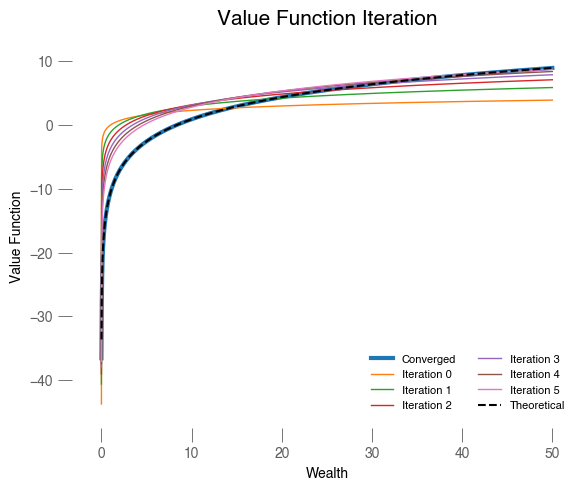

In [5]:
theme = load_theme("minimal_light")
theme.apply()
ax0 = plt.figure() 
ax0.set_facecolor(color)

ax1 = plt.subplot(1,1,1)
plt.plot(w_grid, V, label='Converged', linewidth=3)
plt.plot(w_grid, Vcount[0], label='Iteration 0', linewidth=1)
plt.plot(w_grid, Vcount[1], label='Iteration 1', linewidth=1)
plt.plot(w_grid, Vcount[2], label='Iteration 2', linewidth=1)
plt.plot(w_grid, Vcount[3], label='Iteration 3', linewidth=1)
plt.plot(w_grid, Vcount[4], label='Iteration 4', linewidth=1)
plt.plot(w_grid, Vcount[5], label='Iteration 5', linewidth=1)
plt.plot(w_grid[1:], Vtheory, label = 'Theoretical', linestyle = '--', color = 'k')
plt.ylabel('Value Function')
plt.xlabel('Wealth')
plt.legend(loc='lower right', frameon=False, fontsize=8, ncol = 2)
plt.title(r'Value Function Iteration', fontsize=15, y = 1.05)
ax1.set_facecolor(color)

theme.apply_transforms()

# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.75,
#                     hspace=1.)

plt.show()
ax0.savefig('VFI.jpg', dpi=ax0.dpi, bbox_inches='tight')

In [6]:
#################
## Consumption ##
#################

ctheory = np.empty(11)

for t in range(0, 11):
    ctheory[t] = beta**(t)*(1+r)**(t) * 50 * (1-beta)

    
cdp = np.empty(11)
w = np.empty(12)
w[0] = 50.

for t in range(0, 11):
    for i in range(w_grid.size):
        if w_grid[i] == w[t]:
            windex = i
            
    cdp[t] = w[t] - wprime[windex]/(1+r)
    
    w[t+1] = wprime[windex]
    

In [7]:
################
## Plot Table ##
################

df = pd.DataFrame(ctheory, columns = ['Theory'])
df['Numerical'] = (cdp)
df['Period'] = np.arange(0,11)
df = df.set_index("Period")

white = [{'selector': 'th', 'props': 'background-color: white'}]
borders_right = {'selector': '.row_heading', 'props': 
                 [('border-right', '1px solid #bcbcbc')]}
borders_left = {'selector': f'th:nth-child({2})', 'props': [('border-left', '1px solid #bcbcbc')]}

df.head(11).style \
  .format(precision=3) \
  .set_properties(**{'background-color': color}) \
  .set_table_styles({1: white, 3: white, 5: white, 7: white, 9: white}, axis=1)\
  .set_table_styles([borders_right, borders_left], overwrite=False, axis=1)\
  .set_caption("Optimal Consumption").set_table_styles([{'selector': 'caption', 'props': [('color', 'k'),
              ('font-size', '18px'), ('font-weight', 'bold')]}], overwrite=False)


,Theory,Numerical
Period,,
0,10.000,10.000
1,8.800,8.800
2,7.744,7.738
3,6.815,6.816
4,5.997,5.999
5,5.277,5.281
6,4.644,4.647
7,4.087,4.085
8,3.596,3.598
